<h1><center>Introduction</center></h1>

#### This notebook involves:
- Image augumentaion
- Using inbuild image data generator
- Creating custom CNN model
- Analysing model using Weights and Baises
- Fine tuning VGG16 and MobileNet model

In [38]:
# For numerical computation and file reading
import numpy as np
import pandas as pd

# For creating CNN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy

# For data augumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# For performance evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# For data visualization
import matplotlib.pyplot as plt

# For file handling
import os

import cv2

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import wandb
from wandb.keras import WandbCallback

%matplotlib inline

<img src ="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67">

Weights & Biases helps to track models, visualize model performance and easily automate training and improving models.

In [ ]:
# wandb login
wandb.login()

In [3]:
# Defining the paths for the train, test and validation images
train_path = '../input/chest-xray-pneumonia/chest_xray/train'
test_path = '../input/chest-xray-pneumonia/chest_xray/test'
valid_path = '../input/chest-xray-pneumonia/chest_xray/val'

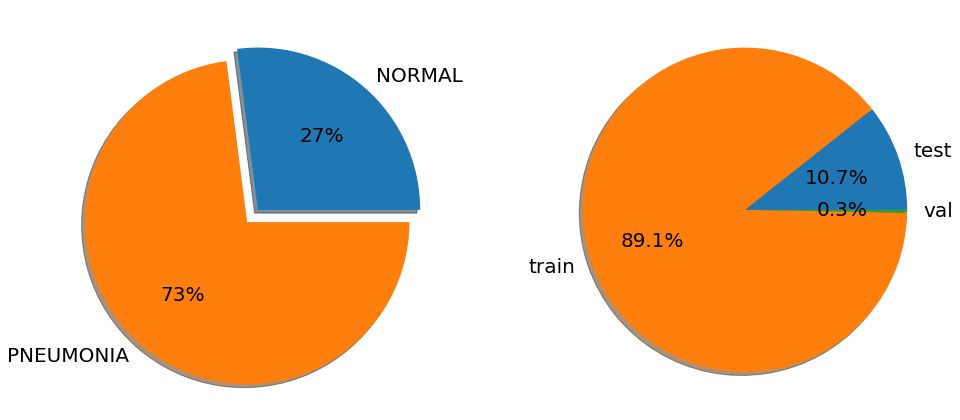

In [4]:
# Visualizing the data size
df = pd.DataFrame()
paths = [train_path, test_path, valid_path]

for path in paths:
    for folder in os.listdir(path):
        count = len(os.listdir(path+'/'+folder))
        path_name = path.split('/')[-1]
        df = df.append({'path': path_name, 'class':folder, "count":count}, ignore_index = True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))

df_class = df.groupby(['class']).sum('count').reset_index()
ax1 = ax1.pie(x= df_class['count'], labels = df_class['class'], autopct='%1.f%%',
              textprops={'fontsize': 20}, shadow=True, startangle=0, explode = (0, 0.1))

df_path = df.groupby(['path']).sum('count').reset_index()
ax2 = ax2.pie(x= df_path['count'], labels = df_path['path'], autopct='%2.1f%%',
              textprops={'fontsize': 20}, shadow=True, startangle=0);

As the images avilable for validation are very less, I will use some of the train images as validation.

In [5]:
# Creating a dataframe for image path and folder
df = pd.DataFrame()
paths = [train_path, test_path, valid_path]

for path in paths:
    for folder in os.listdir(path):
        for image in os.listdir(path+'/'+folder):
            path_name = path.split('/')[-1]
            df = df.append({'Image path':path+'/'+folder+'/'+image,
                            'Type': path_name,
                            'Class':folder},
                           ignore_index = True)
        
display(df.head())
display(df.shape)

,Class,Image path,Type
0,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,train
1,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,train
2,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,train
3,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,train
4,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,train


(5856, 3)

In [6]:
# Number of train, test and validation images
df['Type'].value_counts()

train    5216
test      624
val        16
Name: Type, dtype: int64

In [7]:
# Saving a copy
df_copy = df.copy()

In [8]:
# Creating Train, Test and Validation set

# Converting some train data to validation data
train = df[df['Type']=='train']
train, val = train_test_split(train, train_size=0.8, stratify=train['Class'])

val['Type'].replace('train','val', inplace=True)
val = pd.concat([val, df[df['Type']=='val']])

# Test data
test = df[df['Type']=='test']

In [9]:
# Displaying the final data
display(train.head())
display(val.head())
display(test.head())

print('Training data shape', train.shape)
print('Validation data shape', val.shape)
print('Testing data shape', test.shape)

,Class,Image path,Type
4403,NORMAL,../input/chest-xray-pneumonia/chest_xray/train...,train
2593,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,train
851,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,train
4679,NORMAL,../input/chest-xray-pneumonia/chest_xray/train...,train
1243,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,train


,Class,Image path,Type
2482,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,val
1874,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,val
2623,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,val
780,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,val
665,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/train...,val


,Class,Image path,Type
5216,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/test/...,test
5217,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/test/...,test
5218,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/test/...,test
5219,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/test/...,test
5220,PNEUMONIA,../input/chest-xray-pneumonia/chest_xray/test/...,test


Training data shape (4172, 3)
Validation data shape (1060, 3)
Testing data shape (624, 3)


In [ ]:
# Image shape
width, height = [], []

for i in range(df.shape[0]):
    img = plt.imread(df['Image path'][i])
    
    width.append(img.shape[0])
    height.append(img.shape[1])
    
print('Minimum img height and width are : ', np.min(height), np.min(width))
print('Maximum img height and width are : ', np.max(height), np.max(width))
print('Average img height and width are : ', np.mean(height), np.mean(width))

#### Image dimensions
> The images have different heights and widths. So, I am choosing a target image size of 480x480, which is an arbitary value.

<h2><center>Image Data Generator</center></h2>

#### Augumenting of images
> Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. Image data augmentation is used to expand the training dataset in order to improve the performance and ability of the model to generalize. 

> The main Data augmentation methods are summed up below:

<center><img src ="https://i.imgur.com/1u6h79o.png"></center>

Referance: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks

#### We will apply following augumentations:

- Divide the pixels value by 255 for normalization
- X-rays can view from an angle so, rotation
- They can be view from close, so zoom
- We have to find pneumonia, and not to identify the lungs (left or right), so we can flip the x-rays horizontally
- Adding the width and height shift for making model more robust

> You can choose other augumentations also, I just made it short and simple.

In [10]:
# Creating object for augumenting of images
datagen = ImageDataGenerator(
                            rescale = 1/255,          # Normalization
                            rotation_range = 10,      # randomly rotating images in the range of 0 to 20 degrees
                            zoom_range = 0.1,         # Randomly zoom images upto 20%
                            width_shift_range = 0.05,  # randomly shift images horizontally (fraction of total width)
                            height_shift_range = 0.05, # randomly shift images vertically (fraction of total height)
                            horizontal_flip = True,   # randomly flipping images horizontally
                            vertical_flip = False,     # X rays can't vertically flipped
)

In [12]:
# Hyperparameters
img_height,img_width = 480, 480
batch_size = 64
classes = ['NORMAL', 'PNEUMONIA']
num_classes = len(classes)

In [13]:
# Creating the train and validation batches
train_batches = datagen.flow_from_dataframe(train, x_col='Image path', y_col='Class', target_size = (img_height,img_width), 
                                               classes = classes, batch_size = batch_size, color_mode='grayscale')

valid_batches = datagen.flow_from_dataframe(val, x_col='Image path', y_col='Class', target_size = (img_height,img_width), 
                                               classes = classes, batch_size = batch_size, color_mode='grayscale')

test_batches = datagen.flow_from_dataframe(test, x_col='Image path', y_col='Class', target_size = (img_height,img_width), 
                                               classes = classes, batch_size = batch_size, color_mode='grayscale', shuffle=False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1060 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


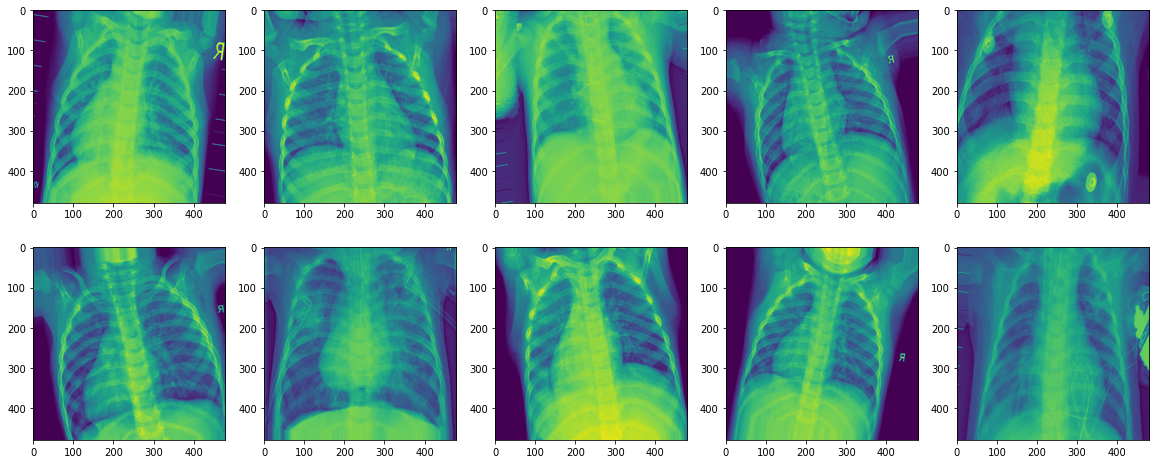

In [14]:
#  Visualizing some of the images
sample = 10
sample_images = train_batches.next()[0][:sample]

fig, ax = plt.subplots(2,5, figsize=(20,8))

for i, axis in zip(range(sample), ax.ravel()):  
    img = sample_images[i]
    axis.imshow(sample_images[i])

<h1><center>Creating a custom CNN model</center></h1>

> I am creating the CNN model with random number of layers, filter size and number of neurons in fully connected layer, but practically we have to do hyperparameter tuning for coming up with best hyperpameters. It can be done with W&B sweep.

In [ ]:
# Creating CNN model
model=Sequential([
    Conv2D(32,(3,3),input_shape=(img_height,img_width,1),activation='relu', padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax') # Last layer has number of neurons equal to number of classes
])

In [ ]:
# model summary
model.summary()

In [ ]:
from keras import backend as K

In [ ]:
# Initializing the wandb
# run = wandb.init(project = 'Chest X-Ray Pneumonia Detection',
#                  config = {'epochs': 20,
#                          'learning_rate': 0.05
#                          })

# config = wandb.config

# Compiling the model
optimizer = keras.optimizers.Adam(learning_rate = 0.001) #config.learning_rate)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

epochs = 3 #config.epochs
history=model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=epochs,
#     callbacks = [WandbCallback(), early_stop]
)

In [ ]:
# Loadactivity_regularizering the best base model obtained after hyperparameter tuning 
base_model = keras.models.load_model('../input/base-model-pneumonia-detection/model-best.h5')

<h1><center>VGG16 model</center></h1>

> I will be using the VGG16 model. It won the ILSVR (ImageNet) competition in 2014. The *16* in VGG16, indicates the number of layers in the model, there is also VGG19 with 19 layers.

<center><img src ="https://miro.medium.com/max/1400/1*smaJBYed3MSsqDodgnJnXw.png"></center>

In [15]:
# Loading the VGG16 model
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 3s 0us/step


In [17]:
# Let's look at the summary of the model
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

<img src="https://miro.medium.com/max/1838/1*NNifzsJ7tD2kAfBXt3AzEg.png">

> There are 1000 neurons in the layers, as the pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. But for our case there are only 2 classes, so we have to change it to 2.

> The size of the input image for VGG16 is 224x224, but we have set the size of input image as 150x150, so we have to modify the image data generator accordingly.

In [16]:
# Reshaping the images to 224x224 for VGG16
train_batches_vgg = datagen.flow_from_dataframe(train, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size)
valid_batches_vgg = datagen.flow_from_dataframe(val, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size)
test_batches_vgg = datagen.flow_from_dataframe(test, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size, shuffle=False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1060 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


<h3><center>Fine tuning VGG16 model</center></h3>

In [18]:
# Copying VGG16 model except for the last layer
model_vgg = Sequential()
for layer in vgg16_model.layers[:-1]:
    model_vgg.add(layer)
    
# Freezing the weights, so we don't have to train then again
for layer in model_vgg.layers[:-3]:
    layer.trainable = False
    
# Adding the last dense layer
# model_vgg.add(Dense(128, activation = 'relu'))
# model_vgg.add(Dropout(0.1))
model_vgg.add(Dense(num_classes, activation = 'softmax'))

In [21]:
# Initializing the wandb
# run = wandb.init(project = 'Chest X-Ray Pneumonia Detection',
#                  config = {'epochs': 10,
#                          'learning_rate': 0.001
#                          })

# config = wandb.config

# Compiling the model
optimizer = keras.optimizers.Adam(learning_rate = 0.001) #config.learning_rate)
model_vgg.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

epochs = 5 #config.epochs
history=model_vgg.fit(x=train_batches_vgg,
    steps_per_epoch=len(train_batches_vgg),
    validation_data=valid_batches_vgg,
    validation_steps=len(valid_batches_vgg),
    epochs=epochs,
#     callbacks = [WandbCallback(), early_stop]
)

Epoch 1/5
66/66 [==============================] - 170s 3s/step - loss: 12.3027 - accuracy: 0.7133 - val_loss: 0.1246 - val_accuracy: 0.9538
Epoch 2/5
66/66 [==============================] - 125s 2s/step - loss: 0.1220 - accuracy: 0.9546 - val_loss: 0.1093 - val_accuracy: 0.9623
Epoch 3/5
66/66 [==============================] - 129s 2s/step - loss: 0.1315 - accuracy: 0.9529 - val_loss: 0.1409 - val_accuracy: 0.9443
Epoch 4/5
66/66 [==============================] - 128s 2s/step - loss: 0.0731 - accuracy: 0.9742 - val_loss: 0.0961 - val_accuracy: 0.9679
Epoch 5/5
66/66 [==============================] - 128s 2s/step - loss: 0.0751 - accuracy: 0.9738 - val_loss: 0.0929 - val_accuracy: 0.9708


> Comparing the tuned VGG16 with best model we created:
<center><img src ="https://i.imgur.com/LR22LU2.png" ></center>

#### Though VGG16 was not trained on the x-rays before, it's performing better than our custom models!!

In [ ]:
model_vgg = keras.models.load_model('../input/base-model-pneumonia-detection/model-best.h5')

In [ ]:
# y_predict = model_vgg.predict_classes(valid_batches_vgg)
# y_true = val['Class'].replace({'NORMAL':0, 'PNEUMONIA':1})
# confusion_matrix(y_true, y_predict)

In [ ]:
# print(classification_report(y_true, y_predict))

<h1><center>MobileNet model</center></h1>

> MobileNets are a class of small, low-latency, low-power models that can be used for classification, detection, and other common tasks convolutional neural networks are good for. Because of their small size, these are considered great deep learning models to be used on mobile devices.

#### Let's try MobileNet model

> To give a quick comparison in regards to size, the size of the full VGG16 network on disk is about 553 MB. The size of one of the currently largest MobileNets is about 17 MB, so that is a huge difference, especially when one thinks about deploying a model to a mobile app or running it in the browser.

<center><img src ="https://i.imgur.com/q5izKji.png"></center>

> This vast size difference is due to the number of parameters within these networks. For example, VGG16 has 138 million parameters, while the 17 megabyte MobileNet we just mentioned has only 4.2 million.

In [ ]:
# Loading MobileNet
mobile = tf.keras.applications.mobilenet.MobileNet()

<h3><center>Fine tuning MobileNet model</center></h3>

> We'll be using this to build a new model. This new model will consist of the original MobileNet up to the sixth to last layer. We're not including the last five layers of the original MobileNet. By looking at the summary of the original model, we can see that by not including the last five layers, we'll be including everything up to and including the last `global_average_pooling` layer. 

>The number *six*, is choose arbitary.

In [ ]:
# Copying MobileNet model except for the last 6 layers
model_mobile = Sequential()
for layer in mobile.layers[:-5]:
    model_mobile.add(layer)

# Adding a dense layer with 2 neurons as we have only 2 classes
model_mobile.add(Dense(64, activation = 'relu'))
model_mobile.add(Dropout(0.2))
model_mobile.add(Dense(num_classes, activation = 'softmax'))

> We still want to keep a lot of what the original MobileNet has already learned from ImageNet by freezing the weights in many of layers, especially earlier ones, but we do indeed need to train some layers since the model still needs to learn features about this new data set.

> I am choosing a arbitary value of 30.

In [ ]:
for layer in model_mobile.layers[:-40]:
    layer.trainable = False

In [ ]:
# Data preprocessing and data Generator for Mobile Net
train_batches_mobile = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(train, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size)
valid_batches_mobile = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(val, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size)
test_batches_mobile = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(test, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size, shuffle=False)

In [ ]:
# Initializing the wandb
run = wandb.init(project = 'Chest X-Ray Pneumonia Detection',
                 config = {'epochs': 10,
                         'learning_rate': 0.001
                         })

config = wandb.config

# Compiling the model
optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
model_mobile.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

epochs = config.epochs
history=model_mobile.fit(x=train_batches_mobile,
    steps_per_epoch=len(train_batches_mobile),
    validation_data=valid_batches_mobile,
    validation_steps=len(valid_batches_mobile),
    epochs=epochs,
    callbacks = [WandbCallback(), early_stop]
)

In [ ]:
model_mobile.evaluate(test_batches_mobile)

<h1><center>Xception</center></h1>

In [ ]:
xception = tf.keras.applications.Xception(input_shape=(480, 480, 3), include_top=False)
xception.summary()

In [ ]:
xception.trainable = False

inputs = keras.Input(shape=(480, 480, 3))
x = xception(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(2, activation='sigmoid')(x)
model_xception = keras.Model(inputs, outputs)

In [ ]:
# Data preprocessing and data Generator for Mobile Net
train_batches_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(train, x_col='Image path', y_col='Class', target_size = (480,480), 
                                               classes = classes, batch_size = batch_size)
valid_batches_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(val, x_col='Image path', y_col='Class', target_size = (480,480), 
                                               classes = classes, batch_size = batch_size)
test_batches_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(test, x_col='Image path', y_col='Class', target_size = (480,480), 
                                               classes = classes, batch_size = batch_size, shuffle=False)

In [ ]:
model_xception.evaluate(test_batches_xception)

In [ ]:
# Initializing the wandb
run = wandb.init(project = 'Chest X-Ray Pneumonia Detection',
                 config = {'epochs': 30,
                         'learning_rate': 0.001
                         })

config = wandb.config

# Compiling the model
optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
model_xception.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

epochs = config.epochs
history=model_xception.fit(x=train_batches_xception,
    steps_per_epoch=len(train_batches_xception),
    validation_data=valid_batches_xception,
    validation_steps=len(valid_batches_xception),
    epochs=epochs,
    callbacks = [WandbCallback(), early_stop]
)

# Loading the models

In [23]:
model_base = keras.models.load_model('../input/base-model-pneumonia-detection/model-best.h5')
model_mobile = keras.models.load_model('../input/base-model-pneumonia-detection/mobilenet.h5')
model_xception = keras.models.load_model('../input/base-model-pneumonia-detection/Xception.h5')
model_vgg16 = keras.models.load_model('../input/base-model-pneumonia-detection/vgg16.h5')

In [24]:
# Evaluating the performance on test set
test_batches = datagen.flow_from_dataframe(test, x_col='Image path', y_col='Class', target_size = (img_height,img_width), 
                                               classes = classes, batch_size = batch_size, color_mode='grayscale', shuffle=False)
test_batches_vgg = datagen.flow_from_dataframe(test, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size, shuffle=False)
test_batches_mobile = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(test, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size, shuffle=False)
test_batches_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(test, x_col='Image path', y_col='Class', target_size = (480,480), 
                                               classes = classes, batch_size = batch_size, shuffle=False)

Found 624 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
print('Base model performance : ', model_base.evaluate(test_batches))
print('Mobile Net model performance : ', model_mobile.evaluate(test_batches_mobile))
print('Xception model performance : ', model_xception.evaluate(test_batches_xception))
print('VGG16 model performance : ', model_vgg16.evaluate(test_batches_vgg))

# Ensemble of models

In [25]:
# Evaluating the performance on test set
train_batches = datagen.flow_from_dataframe(train, x_col='Image path', y_col='Class', target_size = (img_height,img_width), 
                                               classes = classes, batch_size = batch_size, color_mode='grayscale', shuffle=False)
train_batches_vgg = datagen.flow_from_dataframe(train, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size, shuffle=False)
train_batches_mobile = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(train, x_col='Image path', y_col='Class', target_size = (224,224), 
                                               classes = classes, batch_size = batch_size, shuffle=False)
train_batches_xception = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(train, x_col='Image path', y_col='Class', target_size = (480,480), 
                                               classes = classes, batch_size = batch_size, shuffle=False)

Found 4172 validated image filenames belonging to 2 classes.
Found 4172 validated image filenames belonging to 2 classes.
Found 4172 validated image filenames belonging to 2 classes.
Found 4172 validated image filenames belonging to 2 classes.


In [ ]:
# Train data
model_base_prediction = model_base.predict_classes(train_batches)
model_vgg16_prediction = model_vgg16.predict_classes(train_batches_vgg)
model_mobile_prediction = model_mobile.predict_classes(train_batches_mobile)
model_xception_prediction = model_xception.predict(train_batches_xception).argmax(axis=1)

In [26]:
# Testing data
model_base_test = model_base.predict_classes(test_batches)
model_vgg16_test = model_vgg16.predict_classes(test_batches_vgg)
model_mobile_test = model_mobile.predict_classes(test_batches_mobile)
model_xception_test = model_xception.predict(test_batches_xception).argmax(axis=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
# Storing the prediction probability
model_base_test = model_base.predict(test_batches)
model_vgg16_test = model_vgg16.predict(test_batches_vgg)
model_mobile_test = model_mobile.predict(test_batches_mobile)
model_xception_test = model_xception.predict(test_batches_xception)

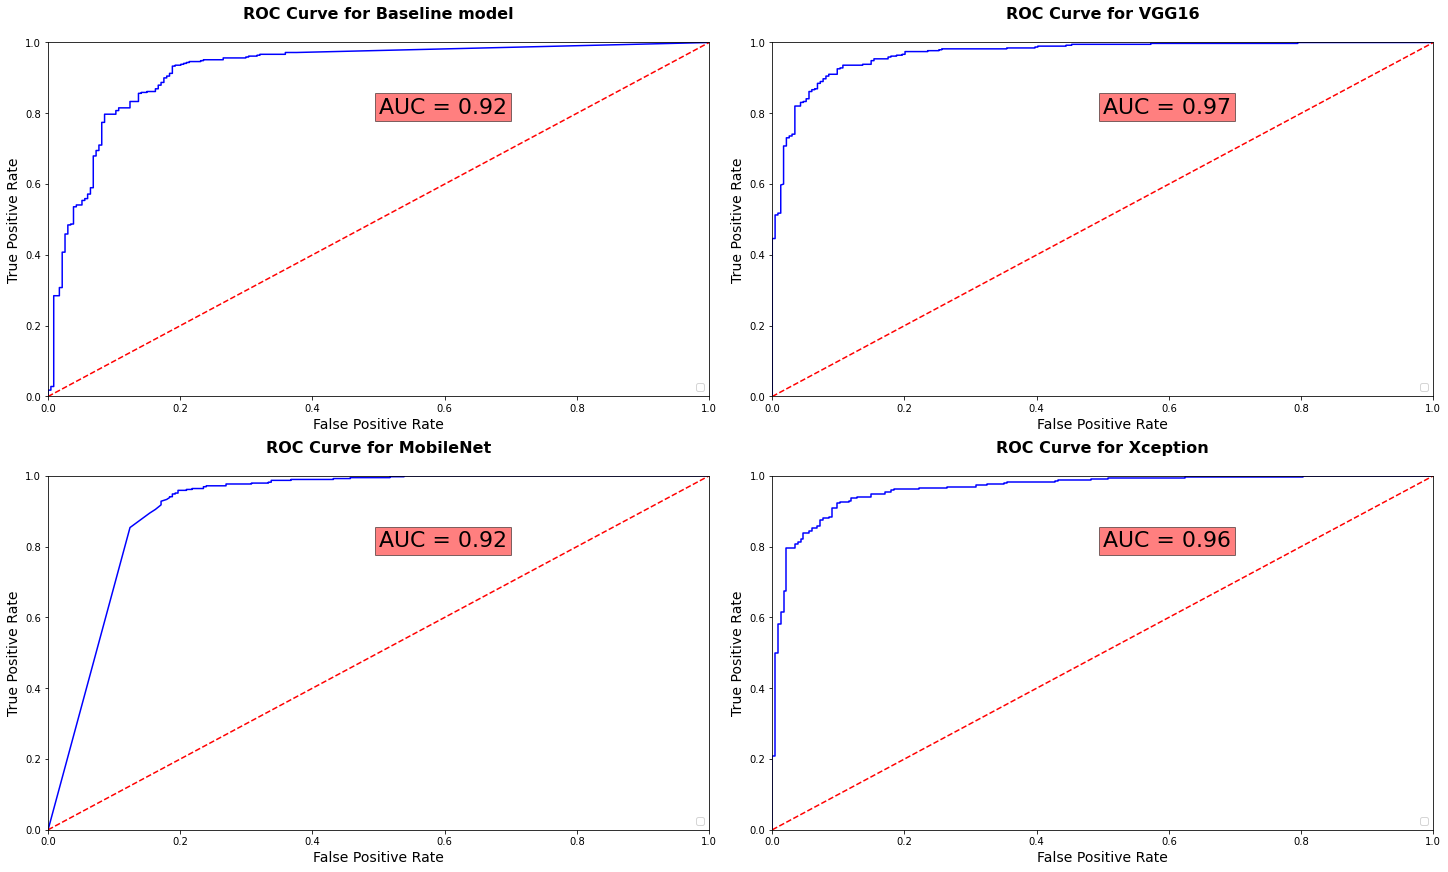

In [53]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2, figsize=(20,12), constrained_layout = True)

models = ['Baseline model', 'VGG16', 'MobileNet', 'Xception']
results = [model_base_test, model_vgg16_test, model_mobile_test, model_xception_test]
axes = [axis1, axis2, axis3, axis4]

for model, result, axis in zip(models, results, axes):
    
    preds = result[:,1]
    y = test_batches.classes
    fpr, tpr, threshold = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    axis.set_title(f"ROC Curve for {model}", fontsize=16, weight='bold', y=1.05)
    axis.text(0.5, 0.8, f"AUC = {round(roc_auc,2)}", fontsize=22, bbox=dict(facecolor='red', alpha=0.5))
    axis.plot(fpr, tpr, 'b')
    axis.legend(loc = 'lower right')
    axis.plot([0, 1], [0, 1],'r--')
    axis.set_xlim([0, 1])
    axis.set_ylim([0, 1])
    axis.set_ylabel('True Positive Rate', fontsize=14)
    axis.set_xlabel('False Positive Rate', fontsize=14);

In [ ]:
from sklearn.linear_model import LogisticRegression

data = pd.DataFrame()
data['Baseline'] = model_base_prediction
data['VGG16'] = model_vgg16_prediction
data['Mobile'] = model_mobile_prediction
data['Xception'] = model_xception_prediction
data['Label'] = train_batches.classes

data_copy = data.copy()

y = data.pop('Label')

# train and test split
X_train, X_test, y_train, y_test = train_test_split(data, y, train_size=0.8, stratify=y)

# creating the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_prediction = lr.predict(X_test)

confusion_matrix(y_test, lr_prediction)

In [ ]:
# Actual test data
test = pd.DataFrame()
test['Baseline'] = model_base_test
test['VGG16'] = model_vgg16_test
test['Mobile'] = model_mobile_test
test['Xception'] = model_xception_test

test_y = test_batches.classes

# Ramdom Forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=5, min_samples_leaf=10)
forest.fit(X_train, y_train)

forest_prediction = forest.predict(test)
confusion_matrix(test_batches.classes, forest_prediction)

#### VGG16 outperform MobineNet and custom CNN model, but we have try other models also like ResNet, GoogleNet, etc to come up with best model. Also, it depends on the dataset too, which algorithm suits it.